In this example, we use CellCnn to analyze a mass cytometry dataset acquired from samples of peripheral
blood mononuclear cells [1]. These samples were exposed to various paracrine agents and their proteomic responses recorded at the single cell level with respect to 14 intracellular signaling markers and 10 cell-surface markers characteristic of immune cell type. We will train CellCnn to classify GM-CSF stimulated and unstimulated samples using only the 14 intracellular markers. To run this example, please [download](http://www.imsb.ethz.ch/research/claassen/Software/cellcnn.html) the preprocessed dataset `GM-CSF_vs_control.pkl` and place it in the `cellCnn/examples` directory. 
    
[1] Bodenmiller, B. *et al.* Multiplexed mass cytometry profiling of cellular states perturbed by small-molecule
   regulators. Nat. Biotechnol. 30, 858–867 (2012).

In [1]:
import os, sys
import numpy as np
import pandas as pd
import cPickle as pickle
import sklearn.utils as sku
import seaborn as sns
import matplotlib.cm as cm

import cellCnn
from cellCnn.utils import mkdir_p
from cellCnn.model import CellCnn

%pylab inline

Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
rand_seed = 12345
np.random.seed(rand_seed)

stim = 'GM-CSF'

WDIR = os.path.join(cellCnn.__path__[0], 'examples')
OUTDIR = os.path.join(WDIR, 'output_%s' % stim)
mkdir_p(OUTDIR)

LOOKUP_PATH = os.path.join(WDIR, '%s_vs_control.pkl' % stim)
lookup =  pickle.load(open(LOOKUP_PATH, 'rb'))

/Users/eiriniar/virtual_env/venv_CellCnn/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Entries in the `lookup` dictionary correspond to mass cytometry samples aquired during different runs. Each `lookup` entry is itself a dictionary with the following fields:

   - `X`: the data matrix (rows correspond to cells, columns to measured markers)
   - `y`: the data labels (`1` for stimulated cells, `0` for unstimulated)
   - `ctype`: cell type as assigned by manual gating
   - `labels`: names of the measured markers


In [3]:
accum_stimulated, accum_unstimulated = [], []
for key, val in lookup.items():
    x = val['X']
    y = val['y']
    accum_stimulated.append(x[y == 1])
    accum_unstimulated.append(x[y == 0])

x_stim = sku.shuffle(np.vstack(accum_stimulated))
x_unstim = sku.shuffle(np.vstack(accum_unstimulated))

# use only the signaling markers for training CellCnn
x_signaling_stim = x_stim[:,10:]
x_signaling_unstim = x_unstim[:,10:]

# the names of the measured markers
labels = lookup[lookup.keys()[0]]['labels']
signaling_labels = labels[10:]

train_samples = [x_signaling_unstim, x_signaling_stim]
train_phenotypes = [0, 1]

# Initialize a CellCnn model with the following configuration:
# Train 3 different networks on subsets of 200 cells each.
# Generate 3000 multi-cell inputs for each class.
# The networks have 3 filters.
# Training stops after looping through the traing data 10 times.

model = CellCnn(nrun=3, ncell=200, nsubset=3000, nfilter_choice=[3],
                coeff_l2=1e-3, max_epochs=10)

# Now fit the model using the training data
model.fit(train_samples, train_phenotypes, OUTDIR)


Generating multi-cell inputs...
Done.
training network: 1
Number of filters: 3
Cells pooled: 1
Train on 6000 samples, validate on 6000 samples
Epoch 1/10
6000/6000 [==============================] - 1s - loss: 0.6457 - acc: 0.5802 - val_loss: 0.5554 - val_acc: 0.9008

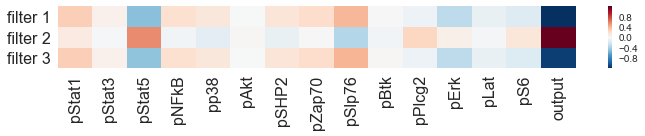

In [4]:
# A fitted model has an extra attribute called `results`
results = model.results

# plot the learned filter weights
# the last column shows the weight connection between each filter and the output node corresponding to stimulation

scaler = results['scaler']
nmark = len(signaling_labels)
filters = results['w_best_net'][:,range(nmark)+[-1]]

plt.figure(figsize=(10, 2))
ax = sns.heatmap(pd.DataFrame(filters,
                              index=['filter 1', 'filter 2', 'filter 3'],
                              columns=signaling_labels+['output']),
                 robust=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

In [5]:
# we will further characterize the cell subsets selected by the filters for a particular mass cytometry run

key = 'Dasatinib'
val = lookup[key]
x = val['X']
y = val['y']
x1 = x[y == 1]

# z-transform the intracellular protein expressions that will be processed by the network
x0_signaling = scaler.transform(x[:,10:])
x_signaling = scaler.transform(x1[:,10:])
x_surface = x1[:,:10]

In [6]:
# compute a t-SNE map

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(StandardScaler().fit_transform(x_surface))

In [7]:
# select the filter with highest (positive) weight connection to the output node corresponding to stimulation

i = np.argmax(results['w_best_net'][:,-1])
w = results['w_best_net'][i,:nmark]
b = results['w_best_net'][i,nmark]
g = np.sum(w.reshape(1,-1) * x_signaling, axis=1) + b
g = g * (g > 0)  # the ReLU function

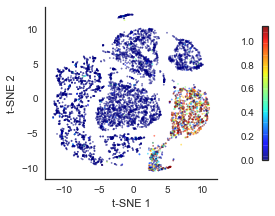

In [8]:
# cell filter activity plot

sns.set_style('white')
plt.figure(figsize=(4, 4))
ax = plt.subplot(aspect='equal')
im = ax.scatter(x_tsne[:,0], x_tsne[:,1], s=2, marker='o', c=g, cmap=cm.jet,
           alpha=0.5, edgecolors='face', vmax=np.percentile(g, 95))
plt.colorbar(im, fraction=0.03, pad=0.2)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
sns.despine()
plt.show()

In [9]:
# set a cell filter activity threshold to define the cell subset selected by the filter

thres = .4
x_surface_pos = x_surface[g > thres]
x_signaling_pos = x_signaling[g > thres]
x_tsne_pos = x_tsne[g > thres]


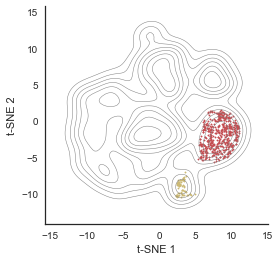

In [10]:
# density-based clustering of the filter-selected cell subset 

from sklearn.cluster import DBSCAN
from collections import Counter
from cellCnn.plotting import set_dbscan_eps

# run the following line to get a histogram of nearest neighbor distances
# it is useful for setting the `eps` parameter in the DBSCAN clustering algorithm
eps = set_dbscan_eps(x_surface_pos, os.path.join(OUTDIR, 'kNN_distances.png'))

cl = DBSCAN(eps=eps, min_samples=5, metric='l1')
pop_clusters = cl.fit_predict(x_surface_pos)
c = Counter(pop_clusters)

cols = np.array(sns.color_palette())[[0,2,4]]
fig, ax = plt.subplots(figsize=(4,4))
sns.kdeplot(x_tsne[:,0], x_tsne[:,1], colors='gray', cmap=None, linewidths=0.5)
i = 0
for key, val in c.items():
    if (key != -1) and (val > 50):
        i += 1
        pop_cond = (pop_clusters == key)
        a_pos = x_tsne_pos[pop_cond]
        ax.scatter(a_pos[:,0], a_pos[:,1], s=2, marker='o', c=cols[i], edgecolors='face')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
sns.despine()
plt.show()

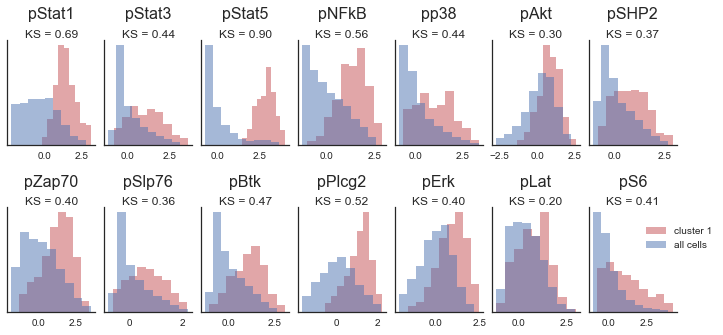

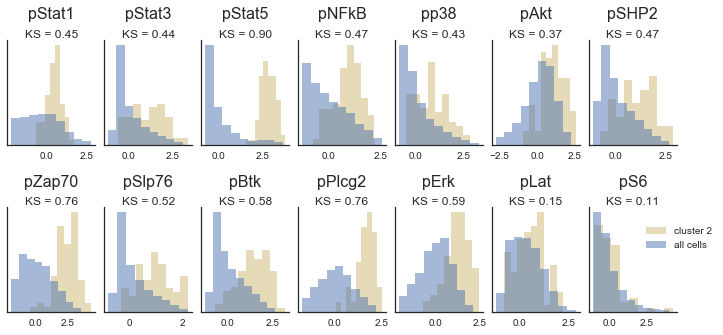

In [11]:
# histograms of measured marker abundances for the whole cell population and the selected cell subsets
# KS: Kolmogorov-Smirnov two-sample test statistic

from scipy.stats import ks_2samp
from cellCnn.plotting import plot_marker_distribution

i = 0
for key, val in c.items():
    if (key != -1) and (val > 50):
        i += 1
        pop_cond = (pop_clusters == key)
        b_pos = x_signaling_pos[pop_cond]
        
        ks_list = []
        for j in range(nmark):
            ks = ks_2samp(b_pos[:,j], x0_signaling[:,j])
            ks_list.append('KS = %.2f' % ks[0])

        plot_marker_distribution([b_pos, x0_signaling], ['cluster %d' % i, 'all cells'],
                                 signaling_labels, grid_size=(2,7), ks_list=ks_list, figsize=(12,5),
                                 colors=cols[[i, 0]], hist=True)